In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# Download the dataset
!git clone https://github.com/AlessioGalluccio/GuyaPredictor

Cloning into 'GuyaPredictor'...
remote: Enumerating objects: 178, done.
remote: Total 178 (delta 0), reused 0 (delta 0), pack-reused 178
Receiving objects: 100% (178/178), 111.18 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
!mkdir training
%cd training
!mkdir Kaguya
!mkdir NotKaguya
%cd ..
!mkdir validation
%cd validation
!mkdir Kaguya
!mkdir NotKaguya
%cd ..

/content/training
/content
/content/validation
/content


In [0]:
import os
import shutil

#copy kaguya images training in training/Kaguya
path_kaguya = 'GuyaPredictor/KaguyaMangaPages'
kaguya_images = sorted(os.listdir(path_kaguya))
for image in kaguya_images:
  shutil.copyfile(os.path.join(path_kaguya, image), os.path.join('training/Kaguya', image))

#copy notKaguya images training in training/NotKaguya
path_notKaguya = 'GuyaPredictor/NotKaguyaMangaPages'
notKaguya_images = sorted(os.listdir(path_notKaguya))
for image in notKaguya_images:
  shutil.copyfile(os.path.join(path_notKaguya, image), os.path.join('training/NotKaguya', image))

In [0]:
def copyImagesFromDirToDir(path_source, path_dest, add_character_prefix = ''):
  images = sorted(os.listdir(path_source))
  for image in images:
    shutil.copyfile(os.path.join(path_source, image), os.path.join(path_dest, add_character_prefix + image))

# ImageGenerator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

SEED = 42

train_path = '/content/training'
validation_path = '/content/validation'

bs = 16
image_size = 224
num_class = len(os.listdir(train_path))

lista = os.listdir(train_path)
lista.sort()

image_datagen = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.2)


train_generator = image_datagen.flow_from_directory(
                        directory= train_path,
                        subset= 'training',
                        target_size=(image_size,image_size),
                        batch_size=bs,
                        classes = lista,
                        color_mode='rgb',
                        shuffle=True,
                        class_mode='binary',
                        seed = SEED)

validation_generator = image_datagen.flow_from_directory(
                        directory= train_path,
                        subset= 'validation',
                        target_size=(image_size,image_size),
                        batch_size=bs,
                        save_to_dir= validation_path, #TODO doesn't work
                        classes = lista,
                        color_mode='rgb',
                        shuffle=True,
                        class_mode='binary',
                        seed = SEED)

Found 130 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [0]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_size, image_size, 3], [None, num_class]))
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_size, image_size, 3], [None, num_class]))

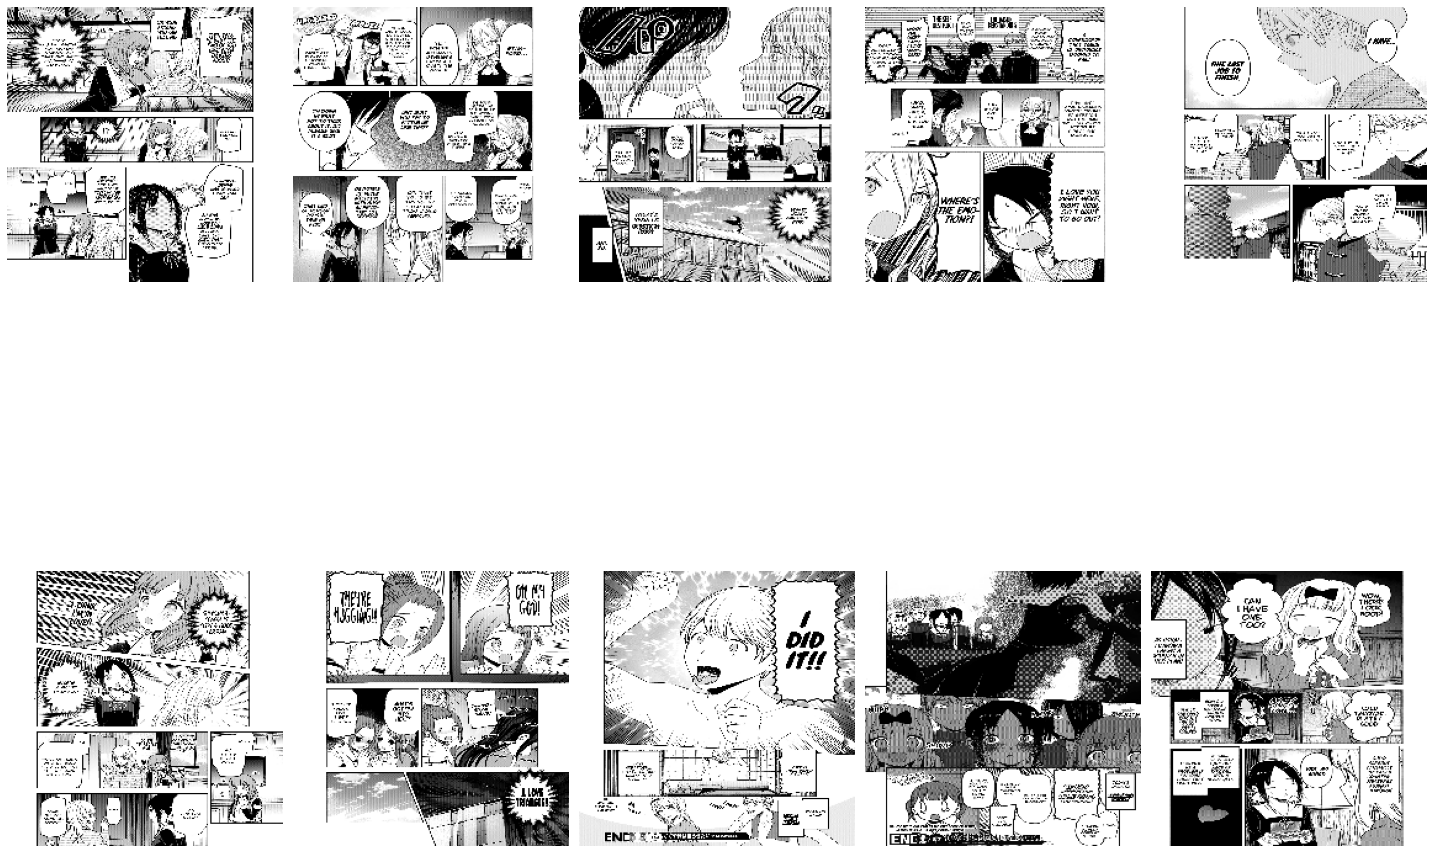

In [8]:
import matplotlib.pyplot as plt

sample_training_images, _ = next(train_generator)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:10])

In [9]:
train_generator.class_indices

{'Kaguya': 0, 'NotKaguya': 1}

# Model

In [0]:
import tensorflow.keras.layers as layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [0]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.BinaryCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
train_generator.samples

130

In [14]:
import os
from datetime import datetime

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    callbacks.append(es_callback)

model.fit(x=train_generator,
          epochs=30,  #### set repeat in training dataset
          steps_per_epoch=int(np.ceil(len(train_generator))),
          validation_data=validation_generator,
          validation_steps=int(np.ceil(len(validation_generator))),
          callbacks=callbacks)

Epoch 1/30
9/9 [==============================] - 3s 386ms/step - loss: 1.0667 - accuracy: 0.6385 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/30
9/9 [==============================] - 3s 371ms/step - loss: 0.7179 - accuracy: 0.6385 - val_loss: 0.6444 - val_accuracy: 0.6562
Epoch 3/30
9/9 [==============================] - 3s 374ms/step - loss: 0.5971 - accuracy: 0.6923 - val_loss: 0.6175 - val_accuracy: 0.6875
Epoch 4/30
9/9 [==============================] - 3s 361ms/step - loss: 0.5259 - accuracy: 0.7385 - val_loss: 0.6281 - val_accuracy: 0.6875


In [0]:
model.save('GuyaPredictor.h5') 

In [16]:
#voglio vedere le predizioni sul validation set
test_datagen = ImageDataGenerator(rescale=1./255)



test_generator = test_datagen.flow_from_directory(directory='validation',
                              # only read images from `test` directory
                              # don't generate labels
                              classes=['iceguya'],
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              # use same size as in training
                              target_size=(image_size, image_size))


pred = model.predict(x=train_generator,
              callbacks = callbacks,
              steps = len(train_generator),
              verbose = 1)
pred

Found 0 images belonging to 1 classes.
9/9 [==============================] - 2s 247ms/step


array([[0.19032562],
       [0.18658632],
       [0.2654934 ],
       [0.13135605],
       [0.17529437],
       [0.24775115],
       [0.16508415],
       [0.22046791],
       [0.1774897 ],
       [0.3240865 ],
       [0.11769536],
       [0.27957684],
       [0.21267763],
       [0.27108672],
       [0.24327713],
       [0.19954023],
       [0.21249373],
       [0.3390985 ],
       [0.16232586],
       [0.20645759],
       [0.1907683 ],
       [0.28971785],
       [0.22700965],
       [0.16533959],
       [0.17474264],
       [0.1822338 ],
       [0.27365136],
       [0.11424721],
       [0.18738376],
       [0.18270607],
       [0.30324954],
       [0.28790337],
       [0.15246524],
       [0.18934487],
       [0.2909423 ],
       [0.17825423],
       [0.22218983],
       [0.17401263],
       [0.24897382],
       [0.20162469],
       [0.19334665],
       [0.18986209],
       [0.15828393],
       [0.1956057 ],
       [0.18391207],
       [0.24056394],
       [0.19325635],
       [0.160

In [0]:
from PIL import Image
import numpy as np
image = Image.open('137_5.png')
# convert image to numpy array
data = np.asarray(image)
data = np.resize(data, (image_size, image_size, 3))
data = np.expand_dims(data, axis=0)

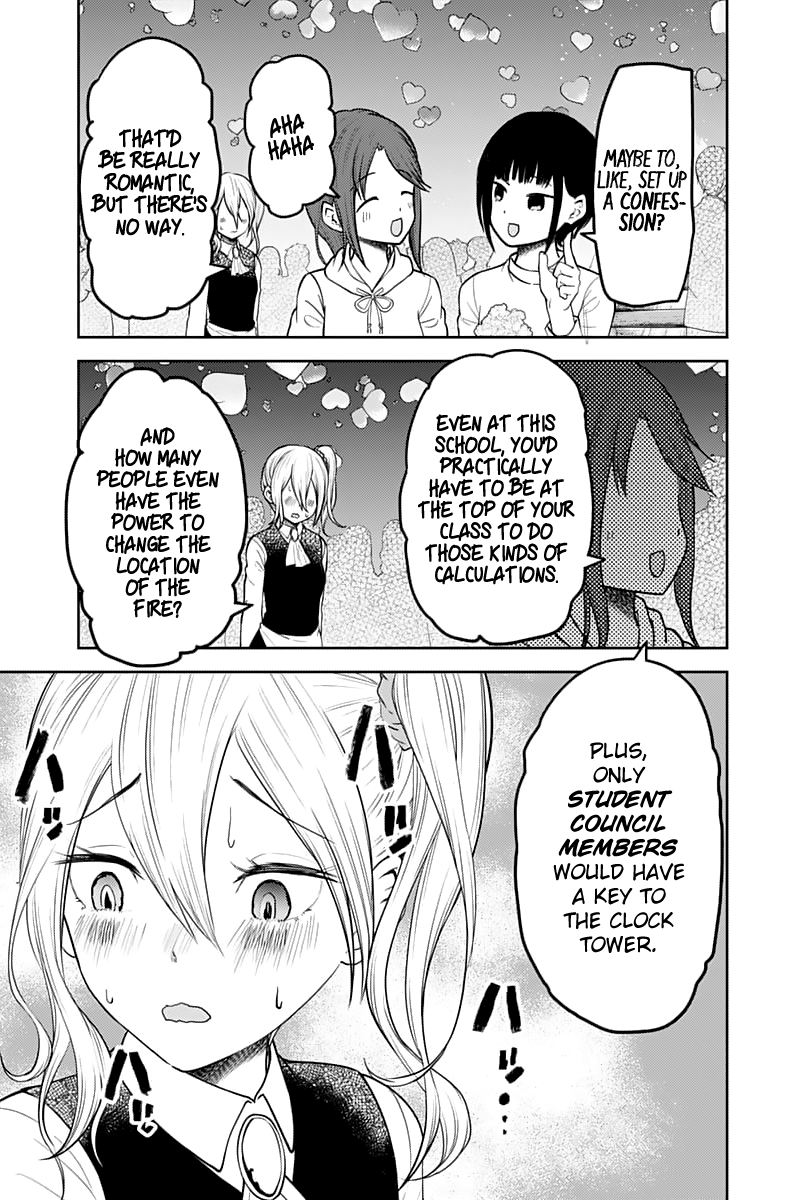

In [22]:
image

In [23]:
data.shape

(1, 224, 224, 3)

In [0]:
x = model.predict(data)

In [25]:
x

array([[0.]], dtype=float32)